## **Step 1 — Unzip the .tgz dataset in Kaggle and check the folders**

In [1]:
import os
import tarfile

### 1) Find the .tgz file inside /kaggle/input

In [2]:
tgz_path = None
for root, _, files in os.walk("/kaggle/input"):
    for f in files:
        if f.endswith(".tgz"):
            tgz_path = os.path.join(root, f)
            break
    if tgz_path:
        break

print("TGZ file:", tgz_path)

TGZ file: /kaggle/input/lfwpeople/lfw-funneled.tgz


### 2) Extract into /kaggle/working (writeable)

In [3]:
extract_dir = "/kaggle/working/lfwpeople_extracted"
os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print("Extracted to:", extract_dir)

Extracted to: /kaggle/working/lfwpeople_extracted


### 3) Show top-level extracted items (to understand structure)

In [4]:
top_items = os.listdir(extract_dir)
print("Top-level items:", top_items[:30])
print("Total top-level items:", len(top_items))

Top-level items: ['lfw_funneled']
Total top-level items: 1


## **Step 2 — Read image paths and labels (names)**

In [5]:
import os

DATA_DIR = "/kaggle/working/lfwpeople_extracted/lfw_funneled"

image_paths = []
labels = []

MIN_IMAGES_PER_PERSON = 10  # important for CNN stability

for person_name in os.listdir(DATA_DIR):
    person_dir = os.path.join(DATA_DIR, person_name)
    if not os.path.isdir(person_dir):
        continue

    images = os.listdir(person_dir)
    if len(images) < MIN_IMAGES_PER_PERSON:
        continue

    for img_name in images:
        if img_name.lower().endswith(".jpg"):
            image_paths.append(os.path.join(person_dir, img_name))
            labels.append(person_name)

print("Total images:", len(image_paths))
print("Total persons:", len(set(labels)))
print("Sample path:", image_paths[0])
print("Sample label:", labels[0])


Total images: 4324
Total persons: 158
Sample path: /kaggle/working/lfwpeople_extracted/lfw_funneled/Jacques_Chirac/Jacques_Chirac_0007.jpg
Sample label: Jacques_Chirac


## **Plotting a sample of images before preprocessing**

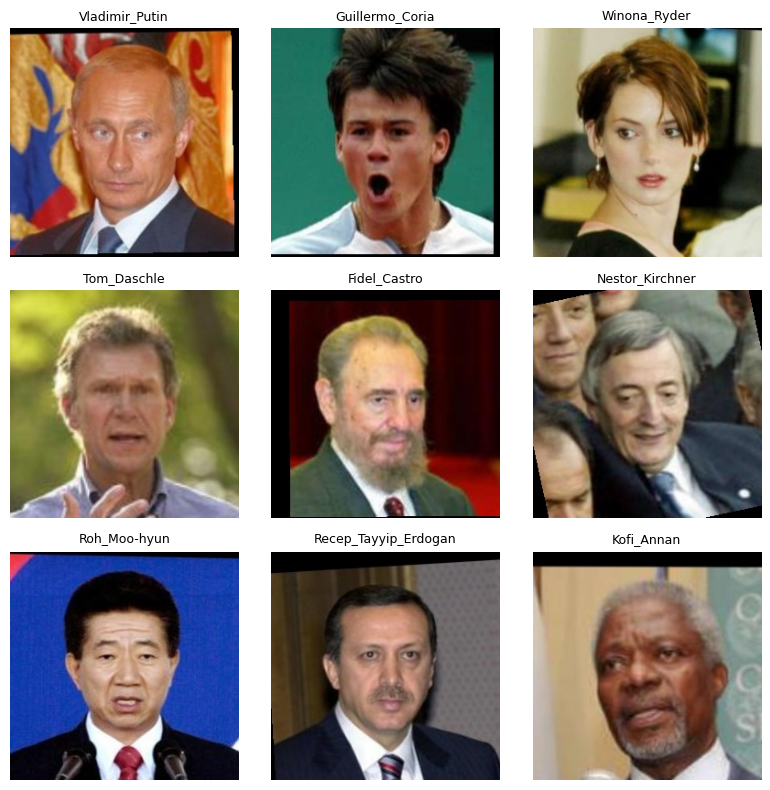

In [6]:
import cv2
import matplotlib.pyplot as plt
import random

# Number of images to show
NUM_SAMPLES = 9

# Randomly choose images
sample_indices = random.sample(range(len(image_paths)), NUM_SAMPLES)

plt.figure(figsize=(8, 8))

for i, idx in enumerate(sample_indices):
    img_path = image_paths[idx]
    label = labels[idx]

    # Read image using OpenCV
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB for matplotlib

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


## **Step 3 — Preprocess images with OpenCV (make them easy for the CNN)**

### we will:

### Resize every face image to the same size (example: 128×128)

### Convert to RGB (or grayscale if you want, but RGB is usually better)

### Normalize pixels to 0 → 1 (instead of 0 → 255)

### Convert labels (names) into numbers, because the model learns with numbers

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [8]:
IMG_SIZE = 128

def preprocess_image(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path)  # BGR
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     # RGB
    img = cv2.resize(img, (img_size, img_size))    # same size for all
    img = img.astype(np.float32) / 255.0           # normalize to 0..1
    return img

In [9]:
# Convert all images
X_list = []
y_list = []

In [10]:
for p, name in zip(image_paths, labels):
    img = preprocess_image(p)
    if img is None:
        continue
    X_list.append(img)
    y_list.append(name)

X = np.array(X_list, dtype=np.float32)
y_names = np.array(y_list)

In [11]:
print("X shape:", X.shape)          # (N, 128, 128, 3)
print("y_names shape:", y_names.shape)
print("Example label:", y_names[0])

X shape: (4324, 128, 128, 3)
y_names shape: (4324,)
Example label: Jacques_Chirac


In [12]:
# Encode names -> numbers
le = LabelEncoder()
y = le.fit_transform(y_names)

num_classes = len(le.classes_)
print("Number of classes (persons):", num_classes)
print("Encoded example:", y[0], "->", le.inverse_transform([y[0]])[0])

Number of classes (persons): 158
Encoded example: 54 -> Jacques_Chirac


## **Step 4 — Split the data and create PyTorch DataLoaders**

### We will:

### Split images into train (80%) and validation (20%)

### Convert NumPy arrays into PyTorch tensors

### Create DataLoaders so the CNN trains in batches (faster + safer for memory)

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### **1) Train / Validation split**

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))

Train samples: 3459
Validation samples: 865


### **2) Custom PyTorch Dataset**


In [16]:
class FaceDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx]).permute(2, 0, 1)  # HWC → CHW
        label = torch.tensor(self.labels[idx]).long()
        return img, label

###  **3) Create datasets**


In [17]:
train_dataset = FaceDataset(X_train, y_train)
val_dataset = FaceDataset(X_val, y_val)

### **# 4) DataLoaders (batching)**

In [18]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### **# 5) Test one batch**

In [20]:
images_batch, labels_batch = next(iter(train_loader))
print("Batch images shape:", images_batch.shape) 
print("Batch labels shape:", labels_batch.shape)

Batch images shape: torch.Size([32, 3, 128, 128])
Batch labels shape: torch.Size([32])


## **Step 5 — Build a simple CNN model (PyTorch)**

### We will build a small CNN with:

#### Conv layers (find patterns)

#### ReLU (helps learning)

#### MaxPool (make it smaller + keep important info)

#### Dropout (reduce overfitting)

#### Fully connected layer (final decision: which person?)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class FaceCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Feature extractor
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # 128x128 -> 128x128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 128x128 -> 128x128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64x64 -> 64x64

        self.pool = nn.MaxPool2d(2, 2)  # halves width/height
        self.dropout = nn.Dropout(0.3)

        # After 3 pools: 128x128 -> 64x64 -> 32x32 -> 16x16
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> 32, 64, 64
        x = self.pool(F.relu(self.conv2(x)))   # -> 64, 32, 32
        x = self.pool(F.relu(self.conv3(x)))   # -> 128, 16, 16

        x = x.view(x.size(0), -1)              # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)                        # raw scores (logits)
        return x

In [23]:
# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceCNN(num_classes=num_classes).to(device)

print("Device:", device)
print(model)

Device: cuda
FaceCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=158, bias=True)
)


In [24]:
# Quick test with one batch
images_batch, labels_batch = next(iter(train_loader))
images_batch = images_batch.to(device)

with torch.no_grad():
    out = model(images_batch)

print("Model output shape:", out.shape) 

Model output shape: torch.Size([32, 158])


## **Step 6 — Train the CNN model**

### We will:

#### Use CrossEntropyLoss (best for multi-class classification)

#### Use Adam optimizer (fast and stable)

#### Train for several epochs

#### Check training and validation accuracy

In [25]:
import torch.optim as optim
from tqdm import tqdm

In [26]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

In [27]:
for epoch in range(EPOCHS):
    # -------- Training --------
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total

    # -------- Validation --------
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Val Accuracy:   {val_acc:.2f}%\n")

Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 119.80it/s]



Epoch 1/10
Train Accuracy: 11.85%
Val Accuracy:   12.25%



Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 133.17it/s]



Epoch 2/10
Train Accuracy: 13.39%
Val Accuracy:   16.76%



Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 130.58it/s]



Epoch 3/10
Train Accuracy: 15.99%
Val Accuracy:   19.42%



Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 127.96it/s]



Epoch 4/10
Train Accuracy: 23.13%
Val Accuracy:   25.78%



Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 125.71it/s]



Epoch 5/10
Train Accuracy: 32.35%
Val Accuracy:   33.18%



Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 136.64it/s]



Epoch 6/10
Train Accuracy: 43.54%
Val Accuracy:   39.88%



Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 140.31it/s]



Epoch 7/10
Train Accuracy: 53.54%
Val Accuracy:   41.50%



Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 133.84it/s]



Epoch 8/10
Train Accuracy: 63.69%
Val Accuracy:   42.20%



Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 125.55it/s]



Epoch 9/10
Train Accuracy: 71.26%
Val Accuracy:   43.47%



Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:00<00:00, 126.48it/s]


Epoch 10/10
Train Accuracy: 77.59%
Val Accuracy:   40.92%



## ***As we see the accuracy is pretty lame and that's because of the dataset is large with so many labels and every label has few images which is not designed to train a model from scratch on***

## **Step 7 — Crop the face (OpenCV) before training**

### we will:

#### detect the face using OpenCV (Haar Cascade)

#### crop the face region (largest face)

#### resize to one fixed size

#### normalize to 0..1

#### This makes the data cleaner, and accuracy usually improves a lot.

In [28]:
IMG_SIZE = 128

# OpenCV built-in Haar Cascade file path
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [29]:
def crop_face_opencv(img_rgb):
    """Return cropped face (RGB) or None if no face found."""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(40, 40)
    )

    if len(faces) == 0:
        return None

    # choose the biggest face
    x, y, w, h = max(faces, key=lambda b: b[2] * b[3])

    # add a small margin around the face
    margin = int(0.2 * max(w, h))
    x1 = max(x - margin, 0)
    y1 = max(y - margin, 0)
    x2 = min(x + w + margin, img_rgb.shape[1])
    y2 = min(y + h + margin, img_rgb.shape[0])

    face = img_rgb[y1:y2, x1:x2]
    return face


In [30]:
X_face_list = []
y_face_list = []
failed = 0

In [31]:
for p, name in tqdm(list(zip(image_paths, labels)), desc="Cropping faces"):
    img_bgr = cv2.imread(p)
    if img_bgr is None:
        failed += 1
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    face = crop_face_opencv(img_rgb)

    if face is None:
        failed += 1
        continue

    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
    face = face.astype(np.float32) / 255.0

    X_face_list.append(face)
    y_face_list.append(name)

Cropping faces: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


In [33]:
face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
face = face.astype(np.float32) / 255.0   # NumPy array
X_face_list.append(face)                 # ✅ NumPy, not tensor
y_face_list.append(name)


print("Original images:", len(image_paths))
print("Kept after face crop:", len(X_face))
print("Failed (no face / bad read):", failed)
print("X_face shape:", X_face.shape)

Original images: 4324
Kept after face crop: 1
Failed (no face / bad read): 0
X_face shape: (1, 128, 128, 3)
